### This script is the extension of previous script replacing Linear_Classifier with DNNClassifier

### Setup

In [1]:
import glob
import io
import os
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
style.use('ggplot')

/usr/local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the Dataset and Randomization

In [2]:
mnist_dataframe = pd.read_csv(
    io.open('mnist_train_small.csv'),
    sep=",",
    header=None)
mnist_dataframe = mnist_dataframe.head(10000)
mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
9192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3177,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1547,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7781,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
display.display(mnist_dataframe.loc[2:3, 10:500])
display.display(mnist_dataframe[0]) # labels
display.display(mnist_dataframe.loc[:, 1:784]) # features

,10,11,12,13,14,15,16,17,18,19,...,491,492,493,494,495,496,497,498,499,500
2,0,0,0,0,0,0,0,0,0,0,...,0,2,129,253,253,15,0,0,0,0
5685,0,0,0,0,0,0,0,0,0,0,...,254,253,169,0,0,0,0,0,0,0
8815,0,0,0,0,0,0,0,0,0,0,...,22,69,197,253,253,135,3,0,0,0
3781,0,0,0,0,0,0,0,0,0,0,...,0,0,145,254,254,254,254,75,0,0
1639,0,0,0,0,0,0,0,0,0,0,...,0,0,3,180,254,171,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,0,0,0,0,0,0,0,0,...,204,240,149,5,0,0,7,93,240,203
9619,0,0,0,0,0,0,0,0,0,0,...,178,254,252,185,160,160,160,115,71,18
8771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,33,253,253,253,117,0
3402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,91,252,41,0,0,0,0


9192    0
3177    2
1547    8
7781    2
92      1
       ..
170     4
9763    0
6427    8
1939    1
1972    4
Name: 0, Length: 10000, dtype: int64

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
9192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1939,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Parse out Labels and Features

In [4]:
def parse_labels_and_features(dataset):
    labels = dataset[0]
    features = dataset.loc[:, 1:784]
    features = features / 255 # gray scale
    return labels, features

### Training set and Validation set

In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
print("Training Targets Summary: ")
display.display(training_targets.describe())
print("Training Examples Summary: ")
display.display(training_examples.describe())

validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
print("Validation Targets Summary: ")
display.display(validation_targets.describe())
print("Validation Examples Summary: ")
display.display(validation_examples.describe())

Training Targets Summary: 


count   7500.0
mean       4.5
std        2.9
min        0.0
25%        2.0
50%        5.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Training Examples Summary: 


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Validation Targets Summary: 


count   2500.0
mean       4.4
std        2.9
min        0.0
25%        2.0
50%        4.0
75%        7.0
max        9.0
Name: 0, dtype: float64

Validation Examples Summary: 


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.3,0.2,1.0,0.2,0.0,0.0,0.0,0.0


### Random Example and its corresponding Label

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
       ..
780   0.0
781   0.0
782   0.0
783   0.0
784   0.0
Name: 14, Length: 784, dtype: float64

8

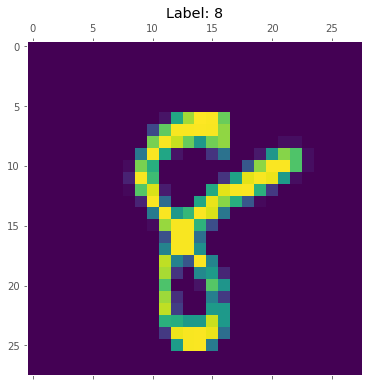

In [6]:
rand_example = np.random.choice(training_examples.index)
display.display(training_examples.loc[rand_example])
display.display(training_targets.loc[rand_example])
plt.figure(figsize=(8, 6))
plt.matshow(training_examples.loc[rand_example].values.reshape(28, 28), fignum=1)
plt.title("Label: %i" % training_targets.loc[rand_example])
plt.grid(False)

In [7]:
mnist_dataframe.loc[rand_example]

0      8
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Name: 14, Length: 785, dtype: int64

### Input Functions

In [8]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
    def _input_fn(num_epochs=None, shuffle=True):
        idx = np.random.permutation(features.index)
        raw_features = {'pixels': features.reindex(idx)}
        raw_targets = np.array(labels[idx])
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(buffer_size=10000)
        
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(features, labels, batch_size):
    def _input_fn():
        raw_features = {"pixels": features.values}
        raw_targets = np.array(labels)
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size)
        
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

### Train Neural Net Classification Model

In [9]:
def train_nn_classification_model(learning_rate,
                                  steps,
                                  batch_size,
                                  hidden_units,
                                  training_examples,
                                  training_targets,
                                  validation_examples,
                                  validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    # Create input functions
    training_input_fn = create_training_input_fn(training_examples,
                                                 training_targets,
                                                 batch_size)
    predict_training_input_fn = create_predict_input_fn(training_examples,
                                                        training_targets,
                                                        batch_size)
    predict_validation_input_fn = create_predict_input_fn(validation_examples,
                                                          validation_targets,
                                                          batch_size)
    
    # Create DNNClassifier object and configure it.
    feature_columns = [tf.feature_column.numeric_column('pixels', 784)]
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns = feature_columns,
        n_classes = 10,
        hidden_units = hidden_units,
        optimizer = my_optimizer
    )
    
    # Train the model in a loop
    print("Training model...")
    print("  LogLoss error (on training data & validation data): ")
    training_error = []
    validation_error = []
    for period in range(0, periods):
        classifier.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Compute probabilities
        training_predicitons = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predicitons])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predicitons])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        
        # Compute loss
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("    Period %02d : %0.2f\t%0.2f" % (period+1,
                                                  training_log_loss,
                                                  validation_log_loss))
        training_error.append(training_log_loss)
        validation_error.append(validation_log_loss)
    print("Model training finished.")
    
    # Remove event files to save disk space
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    
    # Calculate final predictions (not probabilities as above)
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    
    # Graph the LogLoss with respect to Periods
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_error, label="training", color="magenta")
    plt.plot(validation_error, label="validation", color='g')
    plt.legend()
    plt.show()
    
    # Graph Confusion Matrixc
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predtion label")
    plt.show()
    return classifier

Training model...
  LogLoss error (on training data & validation data): 
    Period 01 : 5.69	5.72
    Period 02 : 3.43	3.95
    Period 03 : 2.36	3.16
    Period 04 : 1.77	2.31
    Period 05 : 1.54	2.64
    Period 06 : 1.06	2.21
    Period 07 : 1.27	2.27
    Period 08 : 0.84	1.91
    Period 09 : 0.92	2.02
    Period 10 : 0.86	1.98
Model training finished.
Final accuracy (on validation data): 0.94


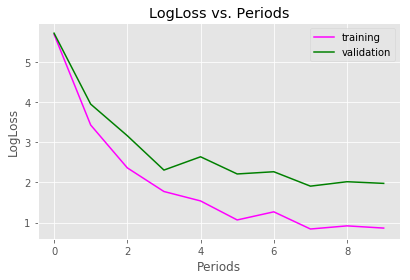

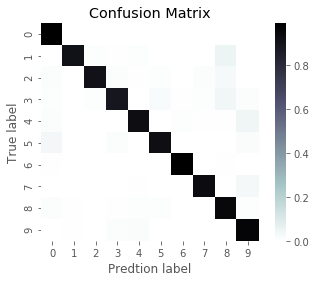

In [10]:
classifier = train_nn_classification_model(
    learning_rate = 0.05,
    steps = 1000,
    batch_size = 30,
    hidden_units = [100, 100],
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

In [11]:
_ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

### Test the Model

In [24]:
mnist_test_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/mnist_test.csv", 
    sep=",", 
    header=None)

mnist_test_dataframe.head()
test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
predict_test_input_fn = create_predict_input_fn(test_examples, test_targets, batch_size=100)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])

accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy (testing data): %0.2f" % accuracy)

Accuracy (testing data): 0.94
